# Analysis1-Prompt Selection

Studying the influence of language-specific prompt tuning on the final results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [19]:
import os
import argparse
import sys
import time
import random
import json
import wandb
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import json
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

from promptsource.templates import Template, DatasetTemplates
from mega.data.load_datasets import load_xnli_dataset, load_xnli_translate_test
from mega.data.data_utils import choose_few_shot_examples
from mega.eval.eval_cls import evaluate_model
from mega.prompting.prompting_utils import load_prompt_template
from mega.prompting.instructions import INSTRUCTIONS
from mega.utils.parser import parse_args
from mega.utils.env_utils import load_openai_env_variables
from mega.prompting.create_lang_prompts import add_prompt_to_dataset

In [4]:
load_env("gpt4v2")

In [5]:
model = "gpt-35-tunro"

In [6]:
MAX_VAL_SIZE = 500
K = 8
TEMPERATURE = 0

## XNLI

In [7]:
langs = ["sw", "ur"]

In [8]:
lang2train_dataset = {
    lang: load_xnli_dataset(lang, split = "train")
    for lang in langs
}

lang2val_dataset = {
    lang: load_xnli_dataset(lang, split = "validation").select(list(range(MAX_VAL_SIZE)))
    for lang in langs
}

lang2test_dataset = {
    lang: load_xnli_dataset(lang, split = "test")
    for lang in langs
}

Found cached dataset xnli (/home/t-kabirahuja/.cache/huggingface/datasets/xnli/sw/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xnli (/home/t-kabirahuja/.cache/huggingface/datasets/xnli/ur/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xnli (/home/t-kabirahuja/.cache/huggingface/datasets/xnli/sw/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xnli (/home/t-kabirahuja/.cache/huggingface/datasets/xnli/ur/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xnli (/home/t-kabirahuja/.cache/huggingface/datasets/xnli/sw/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xnli (/home/t-kabirahuja/.cache/huggingface/datasets/xnli/ur/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
prompt_names = [
#     "take the following as truth",
    "does this imply",
    "GPT-3 style",
    "based on the previous passage",
    "guaranteed true",
    "should assume",
    "must be true",
    "can we infer",
    "justified in saying",
    "claim true/false/inconclusive",
    "consider always/sometimes/never",
    "always/sometimes/never",
    "guaranteed/possible/impossible",
    "MNLI crowdsource"
]

In [18]:
def add_prompts_to_lang_xnli(lang, prompt_name):
    
    prompt_template = load_prompt_template(
        "en", prompt_name, dataset="xnli"
    )
    tgt_prompt_dataset = DatasetTemplates(f"xnli/{lang}")
    add_prompt_to_dataset(
            tgt_prompt_dataset,
            prompt_template,
            lang,
            "en",
            translate=False,
        )

In [11]:
for lang in langs:
    for prompt_name in prompt_names:
        add_prompts_to_lang_xnli(lang, prompt_name)

In [19]:
lang2prompt2acc = {}

for lang in tqdm(langs):
    lang2prompt2acc[lang] = {}
    for prompt_name in tqdm(prompt_names):
        prompt_template = load_prompt_template(
            lang, prompt_name, dataset="xnli"
        )
        acc = evaluate_model(
            train_dataset = lang2train_dataset[lang],
            test_dataset = lang2val_dataset[lang],
            train_prompt_template = prompt_template,
            test_prompt_template = prompt_template,
            model = model,
            few_shot_size = K,
            selection_criteria = "random",
            chat_prompt = True,
            instruction=INSTRUCTIONS.get("xnli", ""),
            save_preds_path = None,
            num_evals_per_sec = 2,
            temperature = TEMPERATURE
        )
        lang2prompt2acc[lang][prompt_name] = acc

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]



  0%|                                                                                                                | 0/500 [00:00<?, ?it/s]

Accuracy: 1.0:   0%|                                                                                                 | 0/500 [00:00<?, ?it/s]

Accuracy: 1.0:   0%|▏                                                                                        | 1/500 [00:00<06:39,  1.25it/s]

Accuracy: 1.0:   0%|▏                                                                                        | 1/500 [00:01<06:39,  1.25it/s]

Accuracy: 1.0:   0%|▎                                                                                        | 2/500 [00:01<06:27,  1.28it/s]

Accuracy: 1.0:   0%|▎                                                                                        | 2/500 [00:02<06:27,  1.28it/s]

Accuracy: 1.0:   1%|▌                                                                                        | 3/500 [00:02<06:23,  1.30it/s

KeyboardInterrupt: 

In [33]:
lang2prompt2acc

{'sw': {}}

## XCOPA

In [7]:
langs = ["ht", "ta"]
en_prompt_accs = [0.72, 0.59]

In [8]:
with open("/home/t-kabirahuja/work/repos/MultilingualBlanketEval/mega/analysis/results/prompt_tuned_xcopa_test_results.json") as f:
    xcopa_test_results = json.load(f)

prompt_tune_accs = [xcopa_test_results[lang] for lang in langs]

In [9]:
prompt_tune_accs

[0.756, 0.544]

In [10]:
exp_analysis_df = pd.DataFrame({
    "Language": langs + langs,
    "Prompt-Tuning": ["English Data", "English Data", "Language-Specific Data", "Language-Specific Data"],
    "Accuracy": en_prompt_accs + prompt_tune_accs
})
exp_analysis_df

,Language,Prompt-Tuning,Accuracy
0,ht,English Data,0.720
1,ta,English Data,0.590
2,ht,Language-Specific Data,0.756
3,ta,Language-Specific Data,0.544


In [11]:
save_dir = "analysis/results/prompt_tuning/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
exp_analysis_df.to_csv(f"{save_dir}/prompt_tuning_results.csv")

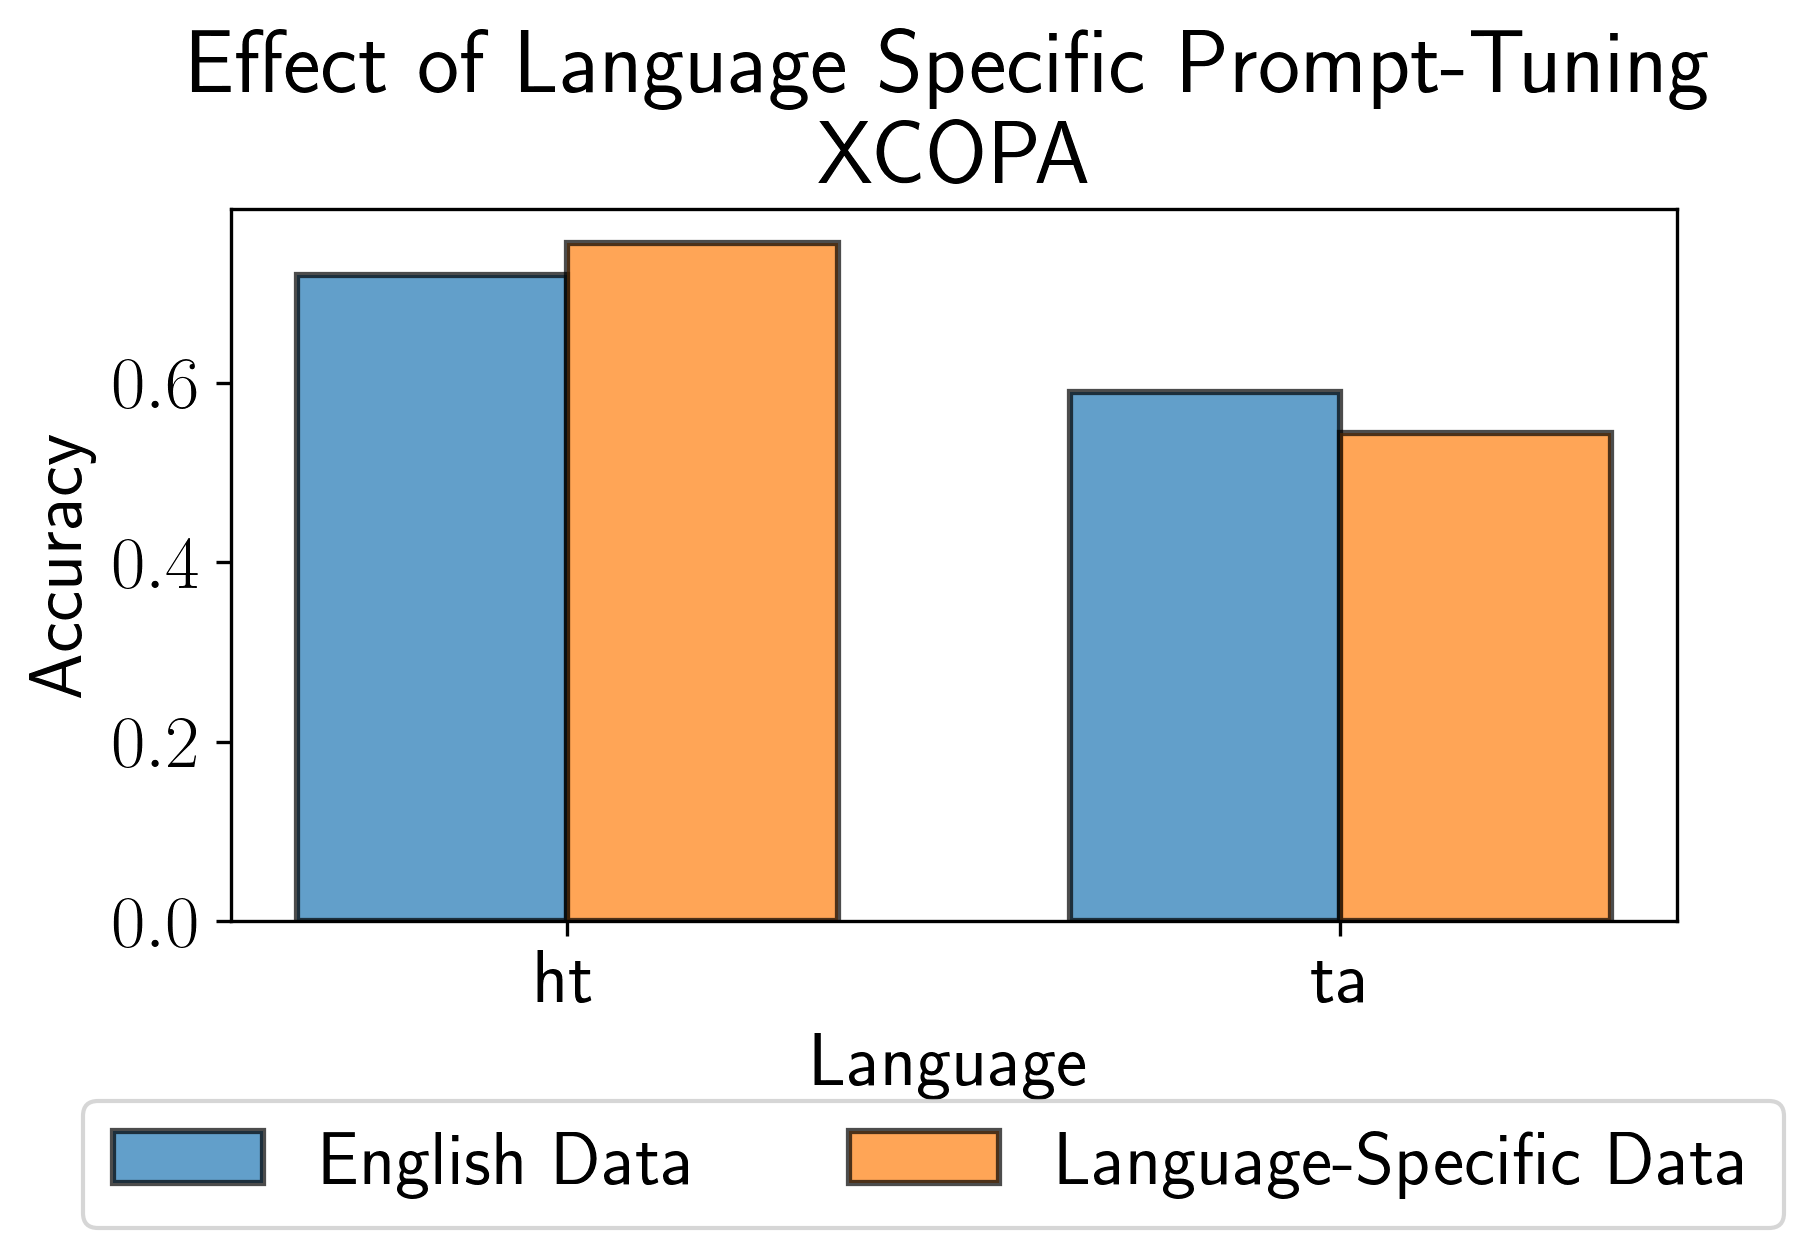

Bad pipe message: %s [b'\xe90\x7f\xbb\xd5nn\x83t\x99\x80kU\xdc\xf0\xadb\x82 \x17pO\x03\x89\xf4\xdb\x8d\xd2\x15\x1f<\xfa~']
Bad pipe message: %s [b'\x0e-\x92BY#\x18\x04\xaa!z\xc0\x99\x10\xc3\xb6\x93\xf2 ?\xdeSN<`\xc8\xa8\xc8\xe0\xa8\xc9Y\xc7\x16\xb9\x9ck\xf7\xf2\x10\x99\x15\xa5l!{\xfd\xc1\x83-\x8f\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03', b'\x08\x08\x08\t\x08\n\x08', b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 ;\xa89\x97\x08_3\xc1I\x07\xb9\xe7r\xf7\xc2O\xcc\x92\xd9X\x93v']
Bad pipe message: %s [b"\xf7!\x86\x00\x19\xb9\x80\x88\x84V\x0cA\x07\xb5gPx\xaf\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc

In [21]:
# Group by Language and Prompt-Tuning, average Accuracy
grouped_df = exp_analysis_df.groupby(['Language', 'Prompt-Tuning']).mean().reset_index()

# Grouped bar plot
fig, ax = plt.subplots()

bar_width = 0.35
alpha = 0.7
linewidth = 1.5
# Positions of the bars on the x-axis
positions = range(len(grouped_df['Language'].unique()))

# Bar plot for Prompt-Tuning = "English Data"
rects1 = ax.bar(positions, grouped_df[grouped_df['Prompt-Tuning'] == "English Data"]['Accuracy'], bar_width,
                alpha=alpha, label='English Data', edgecolor="k", linewidth=linewidth)

# Bar plot for Prompt-Tuning = "Language-Specific Data"
rects2 = ax.bar([p + bar_width for p in positions], grouped_df[grouped_df['Prompt-Tuning'] == "Language-Specific Data"]['Accuracy'], bar_width,
                alpha=alpha, label='Language-Specific Data',edgecolor="k", linewidth=linewidth)

# Set x-axis tick labels as language names
ax.set_xticks([p + bar_width / 2 for p in positions])
ax.set_xticklabels(grouped_df['Language'].unique())

# Set axis labels and title
ax.set_xlabel('Language')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Language Specific Prompt-Tuning\nXCOPA')



# Add legend
# Add legend
ax.legend(ncols=2, bbox_to_anchor = (1.1, -0.2))

plt.savefig(f"{save_dir}/xcopa_prompt_tuning.pdf", bbox_inches = "tight")
plt.savefig(f"{save_dir}/xcopa_prompt_tuning.png", bbox_inches = "tight", dpi=300)


# Display the plot
plt.tight_layout()
plt.show()